# Load libraries and set the coordinate system

In [1]:
%pylab inline

import numpy as np
import cvxpy
from cvxpy import Variable, Minimize, sum_squares, norm, Problem, Parameter, mul_elemwise, sum_entries, Constant
from scipy import sparse
import sys, argparse
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import sys

sys.path.append('../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from joblib import Parallel, delayed
import multiprocessing

"""
Set up the domain and the grid
"""

x_obs_positions = np.arange(50)
y_obs_positions = np.arange(50)

dx = abs(x_obs_positions[1]-x_obs_positions[0])
dy = abs(y_obs_positions[1]-y_obs_positions[0])

N = len(x_obs_positions)
M = len(y_obs_positions)

coords = [[ [x,y] for y in y_obs_positions] for x in x_obs_positions]
coords = np.array([item for sublist in coords for item in sublist])
distances = ((coords[:,0]-25)**2 + (coords[:,1]-25)**2)**0.5
angles = np.arctan2(coords[:,1]-25,coords[:,0]-25)

a = 10
b = 13 # stress support
c = 15 # cell boundary



Populating the interactive namespace from numpy and matplotlib


# Generate the stress field

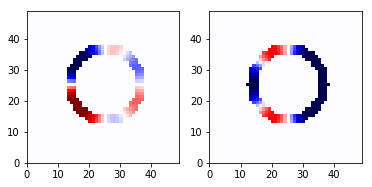

In [2]:
CUTOFF  = 20

fr = 1e-4
ftheta = 1e-4

m = 2
n = 1

condition_outside = (distances > c) * (distances < c + CUTOFF)
condition_inside = distances <=c

stress_r = 0 + (distances>=a) * (distances<=b) * fr * np.sin(m*angles)
stress_theta = 0 + (distances>=a) * (distances<=b) * ftheta * np.cos(n*angles)

stress_x = stress_r*cos(angles) -stress_theta*sin(angles)
stress_y = stress_r*sin(angles) + stress_theta*cos(angles)

s_x = stress_x[condition_inside]
s_y = stress_y[condition_inside]

# build the stress field

x_out = np.array(coords[condition_outside,0]/dx,dtype=int)
y_out = np.array(coords[condition_outside,1]/dy,dtype=int)

x_in = np.array(coords[condition_inside,0]/dx,dtype=int)
y_in = np.array(coords[condition_inside,1]/dy,dtype=int)

plt.subplot(121)
plt.pcolormesh(x_obs_positions,y_obs_positions,stress_x.reshape((50,50)).transpose(),
                           cmap='seismic_r',vmax = 1e-4, vmin=-1e-4).axes.set_aspect('equal')
plt.subplot(122)
plt.pcolormesh(x_obs_positions,y_obs_positions,stress_y.reshape((50,50)).transpose(),
                           cmap='seismic_r',vmax = 1e-4, vmin=-1e-4).axes.set_aspect('equal')

# Generate linear system matrices

In [3]:
def gen_matrices(x_in,y_in,x_out,y_out,dx,dy):

    x_center = np.mean(x_in)
    y_center = np.mean(y_in)
    n_in = len(x_in)
    n_out = len(x_out)

    print("Size of the problem is " + str( n_in + n_out))

    deltax_in_in = x_in[...,np.newaxis] - x_in[np.newaxis, ...]  # should be x-x'
    deltax_out_in = x_out[...,np.newaxis] - x_in[np.newaxis, ...]  # should be x-x'
    deltay_in_in = y_in[...,np.newaxis] - y_in[np.newaxis, ...]  # y - y'
    deltay_out_in = y_out[...,np.newaxis] - y_in[np.newaxis,...] # y - y'

    l2_in_plus_in_plus = (np.array([deltax_in_in*dx - dx/2.0, deltay_in_in*dy - dy/2.0])**2).sum(axis=0)**0.5
    l2_in_plus_in_minus = (np.array([deltax_in_in*dx - dx/2.0, deltay_in_in*dy + dy/2.0])**2).sum(axis=0)**0.5
    l2_in_minus_in_plus = (np.array([deltax_in_in*dx + dx/2.0, deltay_in_in*dy - dy/2.0])**2).sum(axis=0)**0.5
    l2_in_minus_in_minus = (np.array([deltax_in_in*dx + dx/2.0, deltay_in_in*dy+ dy/2.0]) ** 2).sum(axis=0) ** 0.5

    l2_out_plus_in_plus = (np.array([deltax_out_in*dx - dx/2.0, deltay_out_in*dy - dy/2.0])**2).sum(axis=0)**0.5
    l2_out_plus_in_minus = (np.array([deltax_out_in*dx - dx/2.0, deltay_out_in*dy + dy/2.0])**2).sum(axis=0)**0.5
    l2_out_minus_in_plus = (np.array([deltax_out_in*dx + dx/2.0, deltay_out_in*dy - dy/2.0])**2).sum(axis=0)**0.5
    l2_out_minus_in_minus = (np.array([deltax_out_in*dx + dx/2.0, deltay_out_in*dy + dy/2.0]) ** 2).sum(axis=0) ** 0.5

    x_adjacency = sparse.csr_matrix((deltax_in_in == -1)*(deltay_in_in == 0)*-1 + (deltax_in_in == 1)*(deltay_in_in == 0)*1)
    y_adjacency = sparse.csr_matrix((deltay_in_in == -1)*(deltax_in_in == 0)*-1 + (deltay_in_in == 1)*(deltax_in_in == 0)*1)

    A_in_in_x = fxx(deltax_in_in*dx-dx/2. , deltay_in_in*dy-dy/2.0 , l2_in_plus_in_plus) - \
              fxx(deltax_in_in*dx-dx/2. , deltay_in_in*dy+dy/2.0, l2_in_plus_in_minus) -\
              fxx(deltax_in_in*dx+dx/2. , deltay_in_in*dy-dy/2.0, l2_in_minus_in_plus) + \
              fxx(deltax_in_in*dx+dx/2. , deltay_in_in*dy+dy/2.0, l2_in_minus_in_minus)

    A_out_in_x = fxx(deltax_out_in*dx-dx/2. , deltay_out_in*dy-dy/2.0 , l2_out_plus_in_plus) - \
              fxx(deltax_out_in*dx-dx/2. , deltay_out_in*dy+dy/2.0, l2_out_plus_in_minus) -\
              fxx(deltax_out_in*dx+dx/2. , deltay_out_in*dy-dy/2.0, l2_out_minus_in_plus) + \
              fxx(deltax_out_in*dx+dx/2. , deltay_out_in*dy+dy/2.0, l2_out_minus_in_minus)

    D_in_in_x = fxy(deltax_in_in*dx-dx/2. , deltay_in_in*dy-dy/2.0 , l2_in_plus_in_plus) - \
              fxy(deltax_in_in*dx-dx/2. , deltay_in_in*dy+dy/2.0, l2_in_plus_in_minus) - \
              fxy(deltax_in_in*dx+dx/2. , deltay_in_in*dy-dy/2.0, l2_in_minus_in_plus) + \
              fxy(deltax_in_in*dx+dx/2. , deltay_in_in*dy+dy/2.0, l2_in_minus_in_minus)

    D_out_in_x = fxy(deltax_out_in*dx-dx/2. , deltay_out_in*dy-dy/2.0 , l2_out_plus_in_plus) - \
               fxy(deltax_out_in*dx-dx/2. , deltay_out_in*dy+dy/2.0, l2_out_plus_in_minus) - \
               fxy(deltax_out_in*dx+dx/2. , deltay_out_in*dy-dy/2.0, l2_out_minus_in_plus) + \
               fxy(deltax_out_in*dx+dx/2. , deltay_out_in*dy+dy/2.0, l2_out_minus_in_minus)

    B_in_in_x = x_in[..., np.newaxis]*A_in_in_x - fxxx(deltax_in_in-dx/2. , deltay_in_in-dy/2.0 , l2_in_plus_in_plus) + \
                  fxxx(deltax_in_in-dx/2. , deltay_in_in+dy/2.0, l2_in_plus_in_minus) +\
                  fxxx(deltax_in_in+dx/2. , deltay_in_in-dy/2.0, l2_in_minus_in_plus) - \
                  fxxx(deltax_in_in+dx/2. , deltay_in_in+dy/2.0, l2_in_minus_in_minus)

    B_out_in_x = x_out[..., np.newaxis]*A_out_in_x - fxxx(deltax_out_in-dx/2. , deltay_out_in-dy/2.0 , l2_out_plus_in_plus) + \
              fxxx(deltax_out_in-dx/2. , deltay_out_in+dy/2.0, l2_out_plus_in_minus) +\
              fxxx(deltax_out_in+dx/2. , deltay_out_in-dy/2.0, l2_out_minus_in_plus) - \
              fxxx(deltax_out_in+dx/2. , deltay_out_in+dy/2.0, l2_out_minus_in_minus)

    C_in_in_x = y_in[..., np.newaxis]*A_in_in_x - fxxy(deltax_in_in-dx/2. , deltay_in_in-dy/2.0 , l2_in_plus_in_plus) + \
              fxxy(deltax_in_in-dx/2. , deltay_in_in+dy/2.0, l2_in_plus_in_minus) + \
              fxxy(deltax_in_in+dx/2. , deltay_in_in-dy/2.0, l2_in_minus_in_plus) - \
              fxxy(deltax_in_in+dx/2. , deltay_in_in+dy/2.0, l2_in_minus_in_minus)

    C_out_in_x = y_out[..., np.newaxis]*A_out_in_x - fxxy(deltax_out_in-dx/2. , deltay_out_in-dy/2.0 , l2_out_plus_in_plus) + \
               fxxy(deltax_out_in-dx/2. , deltay_out_in+dy/2.0, l2_out_plus_in_minus) + \
               fxxy(deltax_out_in+dx/2. , deltay_out_in-dy/2.0, l2_out_minus_in_plus) - \
               fxxy(deltax_out_in+dx/2. , deltay_out_in+dy/2.0, l2_out_minus_in_minus)

    E_in_in_x = x_in[..., np.newaxis] * D_in_in_x - fxyx(deltax_in_in - dx / 2., deltay_in_in - dy / 2.0,
                                                     l2_in_plus_in_plus) + \
              fxyx(deltax_in_in - dx / 2., deltay_in_in + dy / 2.0, l2_in_plus_in_minus) + \
              fxyx(deltax_in_in + dx / 2., deltay_in_in - dy / 2.0, l2_in_minus_in_plus) - \
              fxyx(deltax_in_in + dx / 2., deltay_in_in + dy / 2.0, l2_in_minus_in_minus)

    E_out_in_x = x_out[..., np.newaxis] * D_out_in_x - fxyx(deltax_out_in - dx / 2., deltay_out_in - dy / 2.0,
                                                       l2_out_plus_in_plus) + \
               fxyx(deltax_out_in - dx / 2., deltay_out_in + dy / 2.0, l2_out_plus_in_minus) + \
               fxyx(deltax_out_in + dx / 2., deltay_out_in - dy / 2.0, l2_out_minus_in_plus) - \
               fxyx(deltax_out_in + dx / 2., deltay_out_in + dy / 2.0, l2_out_minus_in_minus)

    F_in_in_x = y_in[..., np.newaxis]*D_in_in_x - fxyx(deltax_in_in-dx/2. , deltay_in_in-dy/2.0 , l2_in_plus_in_plus) + \
              fxyx(deltax_in_in-dx/2. , deltay_in_in+dy/2.0, l2_in_plus_in_minus) + \
              fxyx(deltax_in_in+dx/2. , deltay_in_in-dy/2.0, l2_in_minus_in_plus) - \
              fxyx(deltax_in_in+dx/2. , deltay_in_in+dy/2.0, l2_in_minus_in_minus)

    F_out_in_x = y_out[..., np.newaxis]* D_out_in_x - fxyx(deltax_out_in-dx/2. , deltay_out_in-dy/2.0 , l2_out_plus_in_plus) + \
               fxyx(deltax_out_in-dx/2. , deltay_out_in+dy/2.0, l2_out_plus_in_minus) + \
               fxyx(deltax_out_in+dx/2. , deltay_out_in-dy/2.0, l2_out_minus_in_plus) - \
               fxyx(deltax_out_in+dx/2. , deltay_out_in+dy/2.0, l2_out_minus_in_minus)

    # u_y measurements      

    A_in_in_y = fxx( deltay_in_in*dy-dy/2.0 , deltax_in_in*dx-dx/2. , l2_in_plus_in_plus) - \
              fxx(deltay_in_in*dy+dy/2.0, deltax_in_in*dx-dx/2. , l2_in_plus_in_minus) -\
              fxx(deltay_in_in*dy-dy/2.0, deltax_in_in*dx+dx/2. , l2_in_minus_in_plus) + \
              fxx(deltay_in_in*dy+dy/2.0, deltax_in_in*dx+dx/2. , l2_in_minus_in_minus)

    A_out_in_y = fxx(deltay_out_in*dy-dy/2.0 , deltax_out_in*dx-dx/2. , l2_out_plus_in_plus) - \
              fxx(deltay_out_in*dy+dy/2.0, deltax_out_in*dx-dx/2. , l2_out_plus_in_minus) -\
              fxx(deltay_out_in*dy-dy/2.0, deltax_out_in*dx+dx/2. , l2_out_minus_in_plus) + \
              fxx(deltay_out_in*dy+dy/2.0, deltax_out_in*dx+dx/2. , l2_out_minus_in_minus)

    D_in_in_y = fxy(deltay_in_in*dy-dy/2.0 , deltax_in_in*dx-dx/2. , l2_in_plus_in_plus) - \
              fxy(deltay_in_in*dy+dy/2.0, deltax_in_in*dx-dx/2. , l2_in_plus_in_minus) - \
              fxy(deltay_in_in*dy-dy/2.0, deltax_in_in*dx+dx/2. , l2_in_minus_in_plus) + \
              fxy(deltay_in_in*dy+dy/2.0, deltax_in_in*dx+dx/2. , l2_in_minus_in_minus)

    D_out_in_y = fxy(deltay_out_in*dy-dy/2.0 , deltax_out_in*dx-dx/2. , l2_out_plus_in_plus) - \
               fxy(deltay_out_in*dy+dy/2.0, deltax_out_in*dx-dx/2. , l2_out_plus_in_minus) - \
               fxy(deltay_out_in*dy-dy/2.0, deltax_out_in*dx+dx/2. , l2_out_minus_in_plus) + \
               fxy(deltay_out_in*dy+dy/2.0, deltax_out_in*dx+dx/2. , l2_out_minus_in_minus)

    B_in_in_y = y_in[..., np.newaxis]*A_in_in_y - fxxx(deltay_in_in-dy/2.0 , deltax_in_in-dx/2. , l2_in_plus_in_plus) + \
                  fxxx(deltay_in_in+dy/2.0, deltax_in_in-dx/2. , l2_in_plus_in_minus) +\
                  fxxx(deltay_in_in-dy/2.0, deltax_in_in+dx/2. , l2_in_minus_in_plus) - \
                  fxxx(deltay_in_in+dy/2.0, deltax_in_in+dx/2. , l2_in_minus_in_minus)

    B_out_in_y = y_out[..., np.newaxis]*A_out_in_y - fxxx(deltay_out_in-dy/2.0 , deltax_out_in-dx/2. , l2_out_plus_in_plus) + \
              fxxx(deltay_out_in+dy/2.0, deltax_out_in-dx/2. , l2_out_plus_in_minus) +\
              fxxx(deltay_out_in-dy/2.0, deltax_out_in+dx/2. , l2_out_minus_in_plus) - \
              fxxx(deltay_out_in+dy/2.0, deltax_out_in+dx/2. , l2_out_minus_in_minus)

    C_in_in_y = x_in[..., np.newaxis]*A_in_in_y - fxxy(deltay_in_in-dy/2.0 , deltax_in_in-dx/2. , l2_in_plus_in_plus) + \
              fxxy(deltay_in_in+dy/2.0, deltax_in_in-dx/2. , l2_in_plus_in_minus) + \
              fxxy(deltay_in_in-dy/2.0, deltax_in_in+dx/2. , l2_in_minus_in_plus) - \
              fxxy(deltay_in_in+dy/2.0, deltax_in_in+dx/2. , l2_in_minus_in_minus)

    C_out_in_y = x_out[..., np.newaxis]*A_out_in_y - fxxy(deltay_out_in-dy/2.0, deltax_out_in-dx/2., l2_out_plus_in_plus) + \
               fxxy(deltay_out_in+dy/2.0, deltax_out_in-dx/2. , l2_out_plus_in_minus) + \
               fxxy(deltay_out_in-dy/2.0, deltax_out_in+dx/2. , l2_out_minus_in_plus) - \
               fxxy(deltay_out_in+dy/2.0, deltax_out_in+dx/2. , l2_out_minus_in_minus)

    E_in_in_y = y_in[..., np.newaxis] * D_in_in_y - fxyx(deltay_in_in - dy / 2.0, deltax_in_in - dx / 2., 
                                                     l2_in_plus_in_plus) + \
              fxyx(deltay_in_in + dy / 2.0, deltax_in_in - dx / 2., l2_in_plus_in_minus) + \
              fxyx(deltay_in_in - dy / 2.0, deltax_in_in + dx / 2., l2_in_minus_in_plus) - \
              fxyx(deltay_in_in + dy / 2.0, deltax_in_in + dx / 2., l2_in_minus_in_minus)

    E_out_in_y = y_out[..., np.newaxis] * D_out_in_y - fxyx(deltay_out_in - dy / 2.0, deltax_out_in - dx / 2., 
                                                       l2_out_plus_in_plus) + \
               fxyx(deltay_out_in + dy / 2.0, deltax_out_in - dx / 2., l2_out_plus_in_minus) + \
               fxyx(deltay_out_in - dy / 2.0, deltax_out_in + dx / 2., l2_out_minus_in_plus) - \
               fxyx(deltay_out_in + dy / 2.0, deltax_out_in + dx / 2., l2_out_minus_in_minus)

    F_in_in_y = x_in[..., np.newaxis]*D_in_in_y - fxyx(deltay_in_in-dy/2.0 , deltax_in_in-dx/2. , l2_in_plus_in_plus) + \
              fxyx(deltay_in_in+dy/2.0, deltax_in_in-dx/2. , l2_in_plus_in_minus) + \
              fxyx(deltay_in_in-dy/2.0, deltax_in_in+dx/2. , l2_in_minus_in_plus) - \
              fxyx(deltay_in_in+dy/2.0, deltax_in_in+dx/2. , l2_in_minus_in_minus)

    F_out_in_y = x_out[..., np.newaxis]* D_out_in_y - fxyx(deltay_out_in-dy/2.0 , deltax_out_in-dx/2. , l2_out_plus_in_plus) + \
               fxyx(deltay_out_in+dy/2.0, deltax_out_in-dx/2. , l2_out_plus_in_minus) + \
               fxyx(deltay_out_in-dy/2.0, deltax_out_in+dx/2. , l2_out_minus_in_plus) - \
               fxyx(deltay_out_in+dy/2.0, deltax_out_in+dx/2. , l2_out_minus_in_minus)


    G_in_in_xx = A_in_in_x + B_in_in_x + C_in_in_x
    G_in_in_xy = D_in_in_x + E_in_in_x + F_in_in_x
    G_out_in_xx = (A_out_in_x + B_out_in_x + C_out_in_x)
    G_out_in_xy = (D_out_in_x + E_out_in_x + F_out_in_x)

    G_in_in_yy = A_in_in_y + B_in_in_y + C_in_in_y
    G_in_in_yx = D_in_in_y + E_in_in_y + F_in_in_y
    G_out_in_yy = (A_out_in_y + B_out_in_y + C_out_in_y)
    G_out_in_yx = (D_out_in_y + E_out_in_y + F_out_in_y)
    
    Dx = sparse.csr_matrix((deltax_in_in == 0)*(deltay_in_in == 0)*-1 + (deltax_in_in == 1)*(deltay_in_in == 0)*1)
    rowsums = np.squeeze(np.asarray((Dx.sum(axis=1) != 0)))
    Dx[rowsums,:] = 0
    Dx.eliminate_zeros()
    Dx = Constant(Dx)

    Dy = sparse.csr_matrix(
        (deltay_in_in == 0) * (deltax_in_in == 0) * -1 + (deltay_in_in == 1) * (deltax_in_in == 0) * 1)
    rowsums = np.squeeze(np.asarray((Dy.sum(axis=1) != 0)))
    Dy[rowsums,:] = 0
    Dy.eliminate_zeros()
    Dy = Constant(Dy)

    return G_in_in_xx, G_in_in_xy, G_out_in_xx, G_out_in_xy, G_in_in_yy, G_in_in_yx, G_out_in_yy, G_out_in_yx, Dx, Dy

G_in_in_xx, G_in_in_xy, G_out_in_xx, G_out_in_xy, G_in_in_yy, G_in_in_yx, G_out_in_yy, G_out_in_yx, Dx, Dy = gen_matrices(x_in,y_in,x_out,y_out,dx,dy)

Size of the problem is 2499


/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [4]:
# Generate the measured dispalcements

u_in_x = G_in_in_xx.dot(s_x) + G_in_in_xy.dot(s_y)
u_out_x = G_out_in_xx.dot(s_x) + G_out_in_xy.dot(s_y)

u_in_y = G_in_in_yx.dot(s_x) + G_in_in_yy.dot(s_y)
u_out_y = G_out_in_yx.dot(s_x)  + G_out_in_yy.dot(s_y)


In [5]:
N_SOLUTIONS = 24
gamma_vals = np.logspace(-5, 0, N_SOLUTIONS)


# Coords are 1:100 in each direction
# annulus centered
# inner radius 20
# outer radius 30
# boundary radius 35

gamma = Parameter(sign="positive",value=1)

n_in = len(x_in)
x_center = np.mean(x_in)
y_center = np.mean(y_in)

sigma_xz = Variable(n_in)
sigma_yz = Variable(n_in)
predicted_in_x = G_in_in_xx * sigma_xz + G_in_in_xy * sigma_yz
predicted_out_x = G_out_in_xx * sigma_xz + G_out_in_xy * sigma_yz
predicted_in_y = G_in_in_yx * sigma_xz + G_in_in_yy * sigma_yz
predicted_out_y = G_out_in_yx * sigma_xz + G_out_in_yy * sigma_yz


error = sum_squares(u_in_x - predicted_in_x) + sum_squares(u_out_x - predicted_out_x) + \
    sum_squares(u_in_y - predicted_in_y) + sum_squares(u_out_y - predicted_out_y)

forceconstraints = [sum_entries(sigma_xz)==0, sum_entries(sigma_yz)==0] # add torque-free constraint here
net_torque = sum_entries(mul_elemwise(x_in-x_center,sigma_yz) - mul_elemwise(y_in-y_center,sigma_xz))

torqueconstraints = [net_torque == 0]

#constraints = forceconstraints + torqueconstraints
constraints = []

In [6]:
regularity_penalty = norm(sigma_xz+sigma_yz,p=1)
objective = Minimize(error + gamma*regularity_penalty)
prob = Problem(objective, constraints)

sq_penalty = []
l1_penalty = []
sigma_xz_values = []
sigma_yz_values = []

u_x_values = []
u_y_values = []

In [7]:
num_cores = multiprocessing.cpu_count() - 4

def invert_one(val):
    gamma.value = val
    try:
        prob.solve(verbose= True, max_iters = 50,
                   warm_start=True, solver = cvxpy.CVXOPT,
                   feastol = 1e-6, reltol = 1e-5,
                   abstol = 1e-6)

    except cvxpy.SolverError:
        return None

    sq_penalty.append(error.value)
    l1_penalty.append(regularity_penalty.value)
    sigma_xz_values.append(sigma_xz.value)
    sigma_yz_values.append(sigma_yz.value)

    s_x = np.zeros(coords.shape[0])
    s_y = np.zeros(coords.shape[0])
    
    s_x[condition_inside] = sigma_xz.value.reshape((n_in,))
    s_y[condition_inside] = sigma_yz.value.reshape((n_in,))

    u_x = np.zeros(coords.shape[0])
    u_y = np.zeros(coords.shape[0])
    u_x[condition_inside] = predicted_in_x.value
    u_x[condition_outside] = predicted_out_x.value
    u_y[condition_inside] = predicted_in_y.value
    u_y[condition_outside] = predicted_out_y.value

    return np.array([s_x, s_y]).T, np.array([u_x, u_y]).T, error.value, regularity_penalty.value, val


#results = Parallel(n_jobs=num_cores)(delayed(invert_one)(val) for val in gamma_vals)


In [8]:
force, u, err, reg, val = invert_one(gamma_vals[-1])

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  2e+03  1e+01  2e+00  1e+00
 1: -6.0248e+00 -3.8936e+00  2e+02  2e+00  3e-01  3e+00
 2: -4.1280e-01 -1.6960e-01  1e+00  2e-02  4e-03  3e-01
 3: -3.8727e-02 -1.4245e-02  1e-01  2e-03  4e-04  3e-02
 4:  7.7190e-03  1.1619e-02  2e-02  4e-04  7e-05  4e-03
 5:  1.6317e-02  1.6990e-02  4e-03  7e-05  1e-05  7e-04
 6:  1.7336e-02  1.7610e-02  2e-03  3e-05  5e-06  3e-04
 7:  1.7860e-02  1.7970e-02  8e-04  1e-05  2e-06  1e-04
 8:  1.8013e-02  1.8052e-02  4e-04  6e-06  1e-06  4e-05
 9:  1.8127e-02  1.8133e-02  6e-05  1e-06  2e-07  7e-06
10:  1.8143e-02  1.8145e-02  2e-05  3e-07  5e-08  2e-06
11:  1.8147e-02  1.8147e-02  3e-06  5e-08  8e-09  2e-07
12:  1.8148e-02  1.8148e-02  2e-07  3e-09  5e-10  1e-08
Optimal solution found.


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:22: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:23: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:27: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:28: DeprecationWarning: assignment will raise an error in the future, most likely because your index r

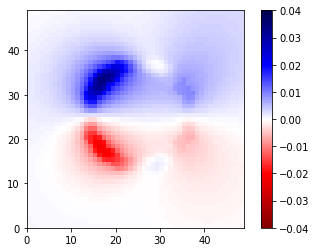

In [9]:
u_x = np.zeros(coords.shape[0])
u_x[condition_inside] = u_in_x
u_x[condition_outside] = u_out_x

plt.pcolormesh(x_obs_positions,y_obs_positions,u_x.reshape((50,50)).transpose(),
                           cmap='seismic_r',vmax = 0.04, vmin=-0.04).axes.set_aspect('equal')
plt.colorbar()

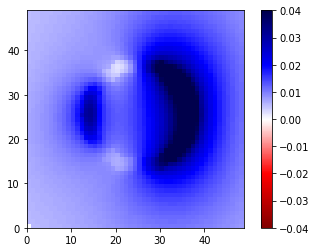

In [10]:
u_y = np.zeros(coords.shape[0])
u_y[condition_inside] = u_in_y
u_y[condition_outside] = u_out_y

plt.pcolormesh(x_obs_positions,y_obs_positions,u_y.reshape((50,50)).transpose(),
                           cmap='seismic_r',vmax = 0.04, vmin=-0.04).axes.set_aspect('equal')
plt.colorbar()

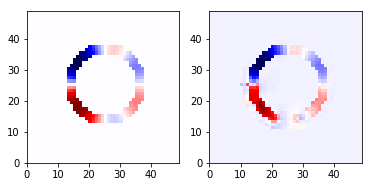

In [11]:
plt.subplot(121)
plt.pcolormesh(x_obs_positions,y_obs_positions,stress_x.reshape((50,50)).transpose(),
                           cmap='seismic_r').axes.set_aspect('equal')

plt.subplot(122)
plt.pcolormesh(x_obs_positions,y_obs_positions,force[:,0].reshape((50,50)).transpose(),
                           cmap='seismic_r').axes.set_aspect('equal')
#plt.colorbar()

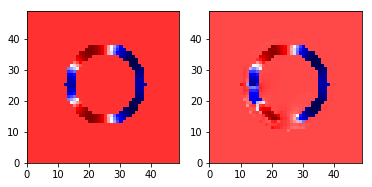

In [12]:
plt.subplot(121)
plt.pcolormesh(x_obs_positions,y_obs_positions,stress_y.reshape((50,50)).transpose(),
                           cmap='seismic_r').axes.set_aspect('equal')

plt.subplot(122)
plt.pcolormesh(x_obs_positions,y_obs_positions,force[:,1].reshape((50,50)).transpose(),
                           cmap='seismic_r').axes.set_aspect('equal')
#plt.colorbar()

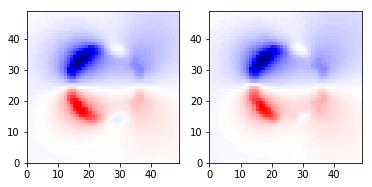

In [13]:
plt.subplot(121)
plt.pcolormesh(x_obs_positions,y_obs_positions,u_x.reshape((50,50)).transpose(),
                           cmap='seismic_r',vmax = 0.04, vmin=-0.04).axes.set_aspect('equal')
plt.subplot(122)
plt.pcolormesh(x_obs_positions,y_obs_positions,u[:,0].reshape((50,50)).transpose(),
                           cmap='seismic_r',vmax = 0.04, vmin=-0.04).axes.set_aspect('equal')
#plt.colorbar()

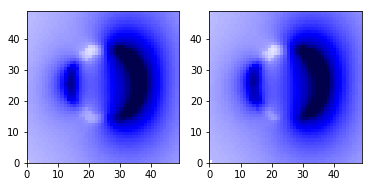

In [14]:
plt.subplot(121)
plt.pcolormesh(x_obs_positions,y_obs_positions,u_y.reshape((50,50)).transpose(),
                           cmap='seismic_r',vmax = 0.04, vmin=-0.04).axes.set_aspect('equal')
plt.subplot(122)
plt.pcolormesh(x_obs_positions,y_obs_positions,u[:,1].reshape((50,50)).transpose(),
                           cmap='seismic_r',vmax = 0.04, vmin=-0.04).axes.set_aspect('equal')
#plt.colorbar()